# Grid search 


La grid search est une méthode d'optimisation utilisée pour trouver de manière systématique la meilleure combinaison de paramètres pour un modèle de machine learning. 

Elle consiste a définir une grille (a grid en anglais) de valeurs possibles pour chaque hyperparamètre (*c'est à dire pour chaque paramètre du modèle*) et à entraîner le modèle pour chaque combinaison possible de ces valeurs : on évalue ensuite les performances du modèle pour chaque combinaison afin de déterminer celle qui donne les meilleurs résultats.

En python elle est implémentée dans la bibliothèque scikit-learn via la classe `GridSearchCV` (*CV pour cross-validation*).

source : [sklearn api](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) & [sklearn user guide](https://scikit-learn.org/stable/modules/grid_search.html)

# 1. Un exemple de grid search sur une régression Ridge

Pour illustrer ce concept, nous allons reprendre le jeu de données **California Housing** et un modèle **Ridge**.

On rappelle que la **régression Ridge** est une régression linéaire avec une régularisation L2 qui réduit les coefficients des variables pour éviter le sur-apprentissage.  
Elle est définie par l’hyperparamètre `alpha`, qui contrôle la force de la régularisation.

Elle s’écrit comme suit :

$$
J(\theta) = \|y - X\theta\|^2_2 + \alpha \|\theta\|^2_2
$$

On l’associe souvent à la **régression Lasso**, qui utilise une régularisation L1 qui peut conduire à des coefficients exactement nuls, permettant ainsi une sélection de variables.

$$
J(\theta) = \|y - X\theta\|^2_2 + \alpha \|\theta\|_1
$$

Moyen mnémotechnique : **R**idge pour **R**éduction des coefficients, **L**asso pour le lasso qui attrape les variables non pertinentes.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.datasets import fetch_california_housing

# récupération des données
housing = fetch_california_housing(as_frame=True, data_home=".")

X, y = housing.data, housing.target

On va ici tester différentes valeurs de 𝛼 pour trouver celle qui donne les meilleurs résultats sur notre jeu de données.

In [6]:
# définition du modèle
model = make_pipeline(StandardScaler(), Ridge())

# définition de la grille de paramètres
param_grid = {"ridge__alpha": np.logspace(-1, 3, 100)}

# définition de la cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=43)

# définition de la grid search avec cross-validation
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",  # on cherche à minimiser la MSE
    n_jobs=-1,  # utilise tous les coeurs de cpu disponibles
    return_train_score=True,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=43, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([1.00000000e-01, 1.09749877e-01, 1.20450354e-01, 1.32194115e-01,
       1.45082878e-01, 1.59228279e-01, 1.74752840e-01, 1.91791026e-01,
       2.10490414e-01, 2.31012970e-01, 2.53536449e...
       1.70735265e+02, 1.87381742e+02, 2.05651231e+02, 2.25701972e+02,
       2.47707636e+02, 2.71858824e+02, 2.98364724e+02, 3.27454916e+02,
       3.59381366e+02, 3.94420606e+02, 4.32876128e+02, 4.75081016e+02,
       5.21400829e+02, 5.72236766e+02, 6.28029144e+02, 6.89261210e+02,
       7.56463328e+02, 8.30217568e+02, 9.11162756e+02, 1.00000000e+03])},
             return_train_score=True, scoring='neg_mean_squared_error')

Comme pour tous les estimateurs de scikit-learn, on peut fitter la GridSearchCV avec la méthode `fit` en lui passant les données d'entrainement (recalculées à chaque fold ici).

In [7]:
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=43, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([1.00000000e-01, 1.09749877e-01, 1.20450354e-01, 1.32194115e-01,
       1.45082878e-01, 1.59228279e-01, 1.74752840e-01, 1.91791026e-01,
       2.10490414e-01, 2.31012970e-01, 2.53536449e...
       1.70735265e+02, 1.87381742e+02, 2.05651231e+02, 2.25701972e+02,
       2.47707636e+02, 2.71858824e+02, 2.98364724e+02, 3.27454916e+02,
       3.59381366e+02, 3.94420606e+02, 4.32876128e+02, 4.75081016e+02,
       5.21400829e+02, 5.72236766e+02, 6.28029144e+02, 6.89261210e+02,
       7.56463328e+02, 8.30217568e+02, 9.11162756e+02, 1.00000000e+03])},
             return_train_score=True, scoring='neg_mean_squared_error')

On peut accéder aux meilleurs paramètres trouvés avec l'attribut `best_params_` et au meilleur estimateur avec l'attribut `best_estimator_`.

Le meilleur paramètre est celui qui minimise la MSE sur les données de validation (ici sur la moyenne des folds de la cross-validation).

In [8]:
grid_search.best_params_

{'ridge__alpha': np.float64(6.5793322465756825)}

In [25]:
grid_search.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=np.float64(6.5793322465756825)))])

In [26]:
best_model = grid_search.best_estimator_
sample_preds = best_model.predict(X.sample(5, random_state=42))
print("Sample predictions by the best model:", sample_preds)

Sample predictions by the best model: [0.7381173  1.76037097 2.67078384 2.84272882 2.61469792]


Et regarder l'historique des résultats avec l'attribut `cv_results_`.

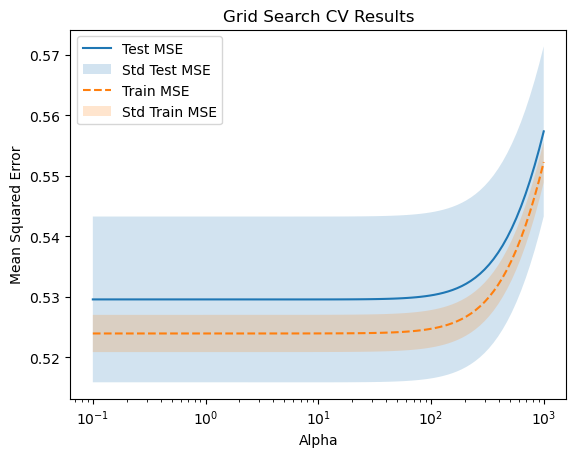

In [9]:
mean_test_scores = -grid_search.cv_results_["mean_test_score"]
std_test_scores = grid_search.cv_results_["std_test_score"]
mean_train_scores = -grid_search.cv_results_["mean_train_score"]
std_train_scores = grid_search.cv_results_["std_train_score"]
alphas = param_grid["ridge__alpha"]

plt.semilogx(alphas, mean_test_scores)
plt.fill_between(
    alphas,
    mean_test_scores - std_test_scores,
    mean_test_scores + std_test_scores,
    alpha=0.2,
)
plt.semilogx(alphas, mean_train_scores, linestyle="--")
plt.fill_between(
    alphas,
    mean_train_scores - std_train_scores,
    mean_train_scores + std_train_scores,
    alpha=0.2,
)
plt.legend(["Test MSE", "Std Test MSE", "Train MSE", "Std Train MSE"])
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("Grid Search CV Results")
plt.show()

# 2. Grid search : méthodologie générale

Comment définir le range des hyperparamètres à tester ? 

- Une bonne règle de base est de tester des valeurs sur une échelle logarithmique, en centrant l'intervalle autour de la valeur par défaut de l'hyperparamètre dans scikit-learn. Par exemple, pour un hyperparamètre dont la valeur par défaut est 1.0, on pourrait tester des valeurs allant de 0.01 à 100.
- Pour définir des plages de valeurs, on utilise np.linspace (espacement linéaire, pas constant) ou np.logspace (espacement logarithmique, pas multiplicatif).

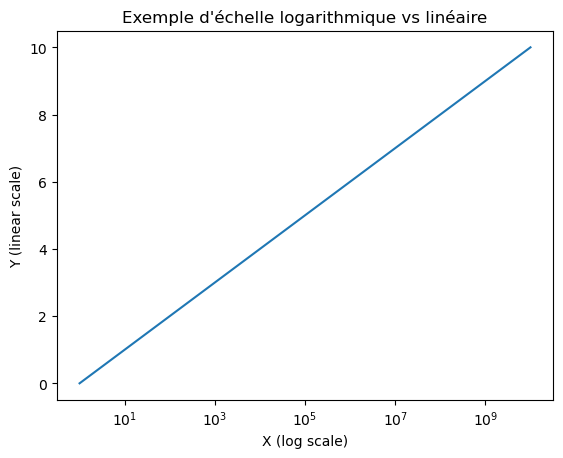

In [28]:
x_log = np.logspace(0, 10, 100)
y_lin = np.linspace(0, 10, 100)

plt.plot(x_log, y_lin)
plt.xscale("log")
plt.xlabel("X (log scale)")
plt.ylabel("Y (linear scale)")
plt.title("Exemple d'échelle logarithmique vs linéaire")
plt.show()

Après une première grid search, on peut affiner la recherche en réduisant l'intervalle autour de la meilleure valeur trouvée, et en augmentant le nombre de points testés dans cet intervalle.

Quel est l'effet de `n_jobs` dans GridSearchCV ?

n_jobs permet de paralléliser les calculs en utilisant plusieurs cœurs de processeur. En définissant n_jobs=-1, on utilise tous les cœurs disponibles. Un petit exemple pour vous convaincre de son utilité :

In [31]:
# sample des données pour accélérer les tests
X_sample, y_sample = X.sample(5, random_state=42), y.sample(5, random_state=42)

In [32]:
%%timeit
test_grid = GridSearchCV(
    model,
    param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=1,  # utilise un seul coeur
    return_train_score=True,
)

test_grid.fit(X_sample, y_sample)

8.58 s ± 2.68 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
test_grid = GridSearchCV(
    model,
    param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,  # utilise tous les coeurs
    return_train_score=True,
)

test_grid.fit(X_sample, y_sample)

2.9 s ± 258 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 3. Pour vous exercer

La combinaison des modèles Ridge et Lasso est appelée ElasticNet. Elle possède deux hyperparamètres : le paramètre de régularisation 𝛼 et le paramètre 𝜌 qui contrôle le mélange entre les deux types de régularisation (L1 et L2).

Effectuez une grid search pour trouver les meilleurs hyperparamètres (𝛼 et 𝜌) pour un modèle ElasticNet sur le jeu de données california housing. Utilisez une cross-validation avec 5 folds et répétez la cross-validation 3 fois. Affichez les meilleurs hyperparamètres trouvés et la performance du modèle sur les données de test.



# 4. Pour aller plus loin 

D'autres méthodes d'optimisation des hyperparamètres existent, comme la recherche aléatoire (*RandomizedSearchCV* dans scikit-learn) ou les méthodes bayésiennes (ex : [Optuna](https://optuna.org/), [Hyperopt](http://hyperopt.github.io/hyperopt/)). Ces méthodes peuvent être plus efficaces que la grid search, surtout lorsque le nombre d'hyperparamètres est élevé.